In [8]:
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics import mechanics
init_vprinting()

from IPython.display import Math
from sympy.interactive import printing

In [9]:
def taylor(xpr, var, center, order=1):
    coefs = []
    t_xpr = 0
    for i in range(order + 1):
        coefs.append(xpr.subs(var, center))
        xpr = xpr.diff(var)
        t_xpr += var ** i * coefs[-1] / factorial(i)
    return t_xpr

def matrix_linearize(xpr, qvars, centers):
    

SyntaxError: incomplete input (1854273318.py, line 11)

# Newtonian Calcs V1

In [10]:
x, phi = dynamicsymbols("x, phi")
t = symbols("t")
dx = x.diff(t)
ddx = dx.diff(t)
dphi = phi.diff(t)
ddphi = dphi.diff(t)
N1, N2, T1, T2 = symbols("N_1 N_2 T_1 T_2")
Ib, Ih = symbols("I_b I_h")
M, m, g = symbols("M m g")
th, l, h, r = symbols("theta l h r")

unknowns = [ddx, ddphi, T2, N1, N2]

In [11]:
h = 0.2
r = 0.1193
l = 0.08
th = asin(l/r)
rh = l + r*cos(th)

M = 0.62369
m = 1.5

Ib = M*r**2 / 2
Ih = m*l**2 / 4
gw = 9.8

print("Theta: %.2f degrees" %(deg(th)))

Theta: 42.11 degrees


In [12]:
px = x + r*sin(phi)
py = r*cos(phi)
dpx = px.diff(t)
ddpx = dpx.diff(t)
dpy = py.diff(t)
ddpy = dpy.diff(t)

In [13]:
eq1 = Eq(sin(phi+th)*N1 + sin(phi-th)*N2 - cos(phi)*T1 + T2, M*ddx) # Ball Fx
eq2 = Eq((T1 + T2), Ib*ddx/r**2)                                    # Ball Torque

eq3 = Eq(-sin(phi+th)*N1 - sin(phi-th)*N2 + cos(phi)*T1, m*ddpx)       # Hat Fx
eq4 = Eq(cos(phi+th)*N1 + cos(phi-th)*N2 - sin(phi)*T1 - m*gw, m*ddpy)  # Hat Fy

# eq5A = Eq((N1-N2)*cos(th) - T1*l*sin(th) - m*gw*h*sin(phi), (Ih + m*rh**2)*ddphi) # Hat Torque v1
eq5B = Eq(r*T1 + m*gw*rh*sin(phi), (Ih+m*rh**2)*ddphi)                            # Hat Torque v2

equs = [eq1, eq2, eq3, eq4, eq5B]

trig_fns = [sin(phi), cos(phi), sin(phi+th), cos(phi+th), sin(phi-th), cos(phi-th)]
lin_subs = [(xpr, taylor(xpr, phi, 0, 1)) for xpr in trig_fns]

# equs = [eq.subs(lin_subs) for eq in equs]
res = solve(equs, unknowns)

NameError: name 'taylor' is not defined

In [14]:
Eq(ddx, res[ddx].factor(T1))

NameError: name 'res' is not defined

In [15]:
Eq(ddphi, res[ddphi])

NameError: name 'res' is not defined

## Stabilization

In [16]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

import control

def linearize(f, xs, q0):
    dfdq = Matrix(np.hstack(f.diff(X.T)[0])).subs([(xs[i], q0[i]) for i in range(len(xs))])
    dfdq.simplify()
    return dfdq

def Lie(f, V, var, order=1):
    if order > 1:
        return Lie(f, Lie(f, V, var, order-1), var)
    return sum([f[i] * V.diff(var[i]) for i in range(len(var))])

In [17]:
f = Matrix([[res[ddx].subs(T1, 0).simplify()],
            [dphi],
            [res[ddphi].subs(T1, 0).simplify()]])
g = Matrix([[res[ddx].subs(phi, 0).subs(T1, 1).simplify()], 
            [0], 
            [res[ddphi].subs(phi, 0).subs(T1, 1).simplify()]])

xs = (dx, phi, dphi)
Lf = lambda V, o=1: Lie(f, V, xs, o)
Lg = lambda V, o=1: Lie(g, V, xs, o)

X = Matrix([dx, phi, dphi])

NameError: name 'res' is not defined

In [35]:
f

⎡⎛                                              2⎞       ⎤
⎢⎝-5.9650415978323⋅cos(φ) + 0.0987667267343509⋅φ̇ ⎠⋅sin(φ)⎥
⎢                                                        ⎥
⎢                           φ̇                            ⎥
⎢                                                        ⎥
⎣                60.3952545058646⋅sin(φ)                 ⎦

In [36]:
g

⎡-0.857704297240541⎤
⎢                  ⎥
⎢        0         ⎥
⎢                  ⎥
⎣ 3.09598906082027 ⎦

In [37]:
A = np.array(linearize(f, X, [0, 0, 0]), dtype=float)
A

array([[ 0.        , -5.9650416 ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        , 60.39525451,  0.        ]])

In [43]:
ffn = lambdify(xs, np.array(f).T[0])
gfn = lambdify(xs, np.array(g).T[0])
def qdot(q, u):
    return ffn(*q) + gfn(*q) * u

A = np.array(linearize(f, X, [0, 0, 0]), dtype=float)
B = np.array([[-0.4], [0], [0.8]])

# Feedback via Pole Placement
pole = -0.2
K = -control.place(A, B, [pole-0.1, pole, pole+0.1])

def u(q):
    return min(max((K @ q)[0], -m*9.8), m*9.8)


# Manually designed u(q)
# def u(q):
#     dx, phi, dphi = q
#     return (-17.8/0.8 - 10)*phi - 3*dphi - 0.3 *dx

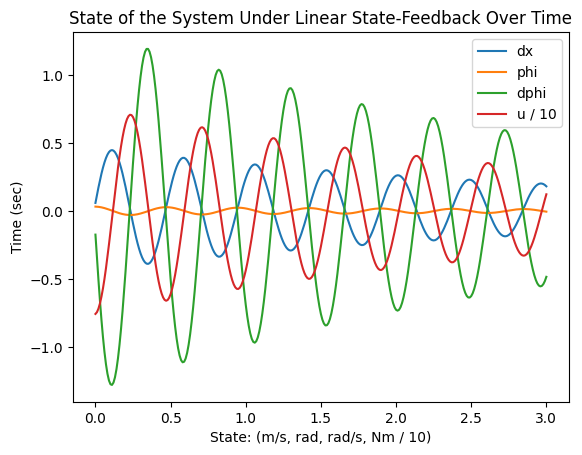

In [44]:
# Simulating the controller
q = np.array([0, 0.1, 0])
time = 0
dt = 0.01

ts = []
qs = []
us = []
while time <3:
    uval = u(q)
    q += qdot(q, uval) * dt
    qs.append(q.copy())
    us.append(uval)
    ts.append(time)
    time += dt

qs = np.array(qs)
us = np.array(us)
plt.plot(ts, qs[:,0])
plt.plot(ts, qs[:,1]/pi)
plt.plot(ts, qs[:,2])
plt.plot(ts, us/10)
plt.legend(["dx", "phi", "dphi", "u / 10"])
plt.xlabel("State: (m/s, rad, rad/s, Nm / 10)")
plt.ylabel("Time (sec)")
plt.title("State of the System Under Linear State-Feedback Over Time")
plt.show()

In [42]:
help(plt.figaspect

SyntaxError: incomplete input (729013264.py, line 1)

# Making Figures

In [34]:
print("Dynamical Equations of the system:")
q = Matrix([x, dx, phi, dphi])
Eq(q.diff(t), Matrix.vstack(Matrix([dx]), f) + Matrix.vstack(Matrix([0]), g) * symbols("tau"))

Dynamical Equations of the system:


      ⎡                                      ẋ                                       ⎤
⎡ẋ⎤   ⎢                                                                              ⎥
⎢ ⎥   ⎢                       ⎛                                             2⎞       ⎥
⎢ẍ⎥   ⎢-0.380735177573813⋅τ + ⎝-3.6654535135169⋅cos(φ) + 0.222222222222222⋅φ̇ ⎠⋅sin(φ)⎥
⎢ ⎥ = ⎢                                                                              ⎥
⎢φ̇⎥   ⎢                                      φ̇                                       ⎥
⎢ ⎥   ⎢                                                                              ⎥
⎣φ̈⎦   ⎣                 0.71330829908216⋅τ + 16.494540810826⋅sin(φ)                  ⎦

In [32]:
Matrix.vstack(Matrix([0]), g)

AttributeError: 'Symbol' object has no attribute 'cols'